<h2 style="text-align:center;" > Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.</h2>

<h2 style="text-align:center;" >Tutorial generacion de teselas</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

#1. INSTALACIÓN DE LIBRERÍAS

In [ ]:
# Librerías geoespaciales esenciales
!pip install -q eemont geemap geopandas rasterio tqdm geojson folium requests

# Correcciones de compatibilidad para geemap
!pip -q uninstall -y tornado && yes | pip install -q tornado==5.1.0
!apt install -y libspatialindex-dev
!pip -q install rtree

# SAM Geo (segmentación)
!pip install -q segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.4/516.4 kB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado 5.1 which is incompatible.
distributed 2024.12.1 requires tornado>=6.2.0, but you have tornado 5.1 which is incompatible.
ipykernel 6.17.1 requires tornado>=6.1, but you have tornado 5.1 which is incompatible.
terminado 0.18.1 requires to

#2. IMPORTACIÓN DE LIBRERÍAS

In [ ]:
import ee
import geemap
import eemont

import geopandas as gpd
import geojson
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm.notebook import tqdm
import os, json, requests, urllib3
#from samgeo import SamGeo

#Para tiles
from shapely.geometry import box
from rasterio.transform import from_origin

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#7. GENERAR TILES

Se debe garantizar que los Tiles generados se ubiquen en la zona de estudio y que contenga la informacion del meta dato de la imagen satelital para poder ubicarlas posteriormente

##7.1. Generación para .tif

In [ ]:
tile_size_tif = 256 # Tamaño del Tile
h, w, _ = rgb_norm.shape
valid_tiles_tif = []
tile_transforms_tif = []  # 💡 Aquí se guardarán los transforms de cada tile válido

guativita_geom = guativita_gdf.geometry.values[0]
minx, miny, maxx, maxy = guativita_gdf.bounds.iloc[0] # Use bounds from the gdf
xres = (maxx - minx) / w
yres = (maxy - miny) / h

for row in range(0, h - tile_size_tif + 1, tile_size_tif):
    for col in range(0, w - tile_size_tif + 1, tile_size_tif):
        tile_tif = rgb_norm[row:row + tile_size_tif, col:col + tile_size_tif, :] # Se escoge si es para norm o uint8
        if np.any(tile_tif > 0):
            # Coordenadas del tile
            x0 = minx + col * xres
            x1 = x0 + tile_size_tif * xres
            y1 = maxy - row * yres
            y0 = y1 - tile_size_tif * yres
            tile_geom_tif = box(x0, y0, x1, y1)

            if guativita_geom.intersects(tile_geom_tif):
                valid_tiles_tif.append(tile_tif)

                # 💡 Guardar la transformada espacial de este tile
                transform_tif = from_origin(x0, y1, xres, yres)
                tile_transforms_tif.append(transform_tif) # Corrected variable name to transform_tif

print(f"🔹 Total de tiles tif válidos tras intersección con Guatavita: {len(valid_tiles_tif)}")

🔹 Total de tiles tif válidos tras intersección con Guatavita: 50


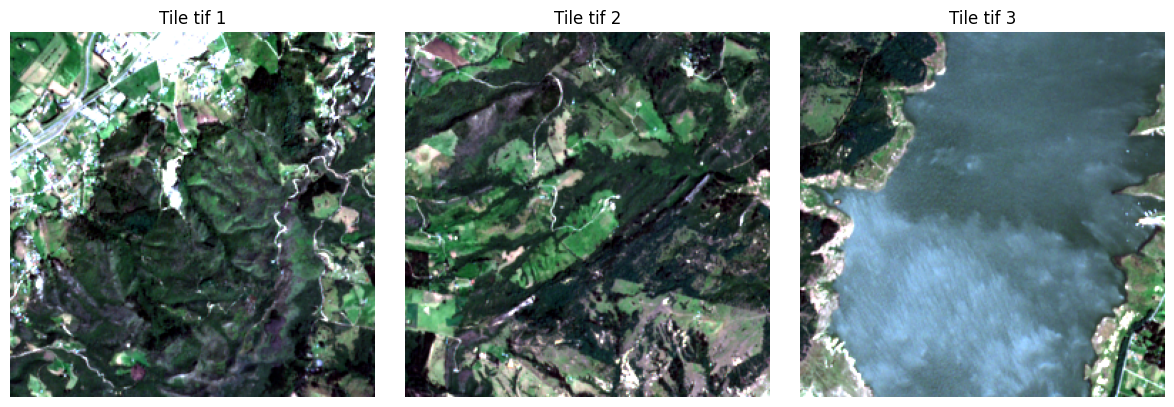

In [ ]:
#Visualizar tiles validos

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    tile_rgb_tif = np.stack([
        valid_tiles_tif[i][:, :, 2],  # B4 - Rojo
        valid_tiles_tif[i][:, :, 1],  # B3 - Verde
        valid_tiles_tif[i][:, :, 0]   # B2 - Azul
    ], axis=-1)

    axs[i].imshow(tile_rgb_tif)
    axs[i].set_title(f"Tile tif {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

##7.2. Generación para uint8

In [ ]:
tile_size_uint8 = 256 # Tamaño del Tile
h, w, _ = rgb_norm.shape
valid_tiles_uint8 = []
tile_transforms_uint8 = []  # 💡 Aquí se guardarán los transforms de cada tile válido

guativita_geom = guativita_gdf.geometry.values[0]
minx, miny, maxx, maxy = guativita_gdf.bounds.iloc[0] # Use bounds from guativita_gdf
xres = (maxx - minx) / w
yres = (maxy - miny) / h

for row in range(0, h - tile_size_uint8 + 1, tile_size_uint8):
    for col in range(0, w - tile_size_uint8 + 1, tile_size_uint8):
        tile_uint8 = rgb_uint8[row:row + tile_size_uint8, col:col + tile_size_uint8, :] # Se escoge si es para norm o uint8
        if np.any(tile_uint8 > 0):
            # Coordenadas del tile
            x0 = minx + col * xres
            x1 = x0 + tile_size_uint8 * xres
            y1 = maxy - row * yres
            y0 = y1 - tile_size_uint8 * yres
            tile_geom_uint8 = box(x0, y0, x1, y1)

            if guativita_geom.intersects(tile_geom_uint8):
                valid_tiles_uint8.append(tile_uint8)

                # 💡 Guardar la transformada espacial de este tile
                transform_uint8 = from_origin(x0, y1, xres, yres)
                tile_transforms_uint8.append(transform_uint8) # Corrected variable name to transform_uint8

print(f"🔹 Total de tiles uint8 válidos tras intersección con Guatavita: {len(valid_tiles_uint8)}") # Changed variable name to valid_tiles_uint8

🔹 Total de tiles uint8 válidos tras intersección con Guatavita: 50


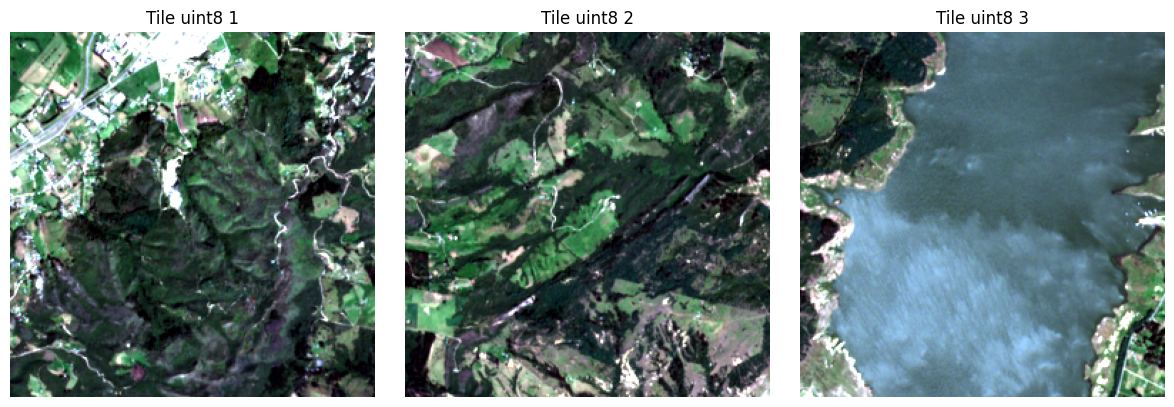

In [ ]:
#Visualizar tiles uint8

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    tile_rgb_uint8 = np.stack([
        valid_tiles_uint8[i][:, :, 2],  # B4 - Rojo
        valid_tiles_uint8[i][:, :, 1],  # B3 - Verde
        valid_tiles_uint8[i][:, :, 0]   # B2 - Azul
    ], axis=-1)

    axs[i].imshow(tile_rgb_uint8)
    axs[i].set_title(f"Tile uint8 {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# 8. SAM

In [ ]:
# 📌 1. Librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import shapes
from rasterio.transform import from_origin
from shapely.geometry import shape
import geopandas as gpd
from samgeo import SamGeo

# 📌 2. Parámetros de SAM
sam_kwargs = {
    "points_per_side": 256,
    "pred_iou_thresh": 0.6,
    "stability_score_thresh": 0.5,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 0,
    "min_mask_region_area": 100
}

sam = SamGeo(model_type="vit_h", automatic=True, erosion_kernel=(3, 3), sam_kwargs=sam_kwargs)

# 📌 3. Ruta de salida
output_geojson = "/content/drive/MyDrive/Sentinel_Export/mascaras_dos_tiles.geojson"
os.makedirs(os.path.dirname(output_geojson), exist_ok=True)

# 📌 4. Procesar SOLO los dos primeros tiles
geoms_tiles = []

for i, (tile, transform) in enumerate(zip(valid_tiles_uint8[:2], tile_transforms_uint8[:2])):
    print(f"\n🔍 Tile {i+1}: tipo={tile.dtype}, rango=({tile.min():.2f}, {tile.max():.2f})")

    try:
        _ = sam.generate(source=tile)
        masks = sam.masks

        if not masks:
            print("⚠️ No se generaron máscaras.")
            continue

        # Visualizar el tile RGB
        tile_rgb = np.stack([tile[:, :, 2], tile[:, :, 1], tile[:, :, 0]], axis=-1)
        plt.figure(figsize=(6, 6))
        plt.imshow(tile_rgb)
        plt.title(f"Tile {i+1} - Imagen RGB")
        plt.axis('off')
        plt.show()

        # Mostrar máscaras
        sam.show_masks()
        sam.show_anns()

        # Raster de índices
        mask_id_raster = np.zeros_like(masks[0]['segmentation'], dtype=np.uint16)
        for idx, m in enumerate(masks, start=1):
            mask_id_raster[m['segmentation']] = idx

        # Convertir a polígonos
        for shape_mask, value in shapes(mask_id_raster, mask=mask_id_raster > 0, transform=transform):
            geom = shape(shape_mask)
            geoms_tiles.append({
                "geometry": geom,
                "properties": {
                    "tile_id": i + 1,
                    "mask_id": int(value)
                }
            })

        print(f"✅ Tile {i+1} — {len(masks)} máscaras convertidas a polígono.")

    except Exception as e:
        print(f"❌ Error en tile {i+1}: {e}")

# 📌 5. Guardar como GeoJSON
gdf = gpd.GeoDataFrame.from_features(geoms_tiles, crs="EPSG:4326")
gdf.to_file(output_geojson, driver="GeoJSON")

print(f"\n✅ GeoJSON guardado en: {output_geojson}")
print(f"🔎 Total de polígonos generados: {len(gdf)}")

# 📌 6. Visualización final
gdf.plot(figsize=(10, 10), cmap="tab20", edgecolor="k")
plt.title("🗺️ Máscaras SAM como polígonos (2 tiles)")
plt.axis('off')
plt.show()




🧩 Tile 1: tipo=uint8, rango=(0.00, 255.00)


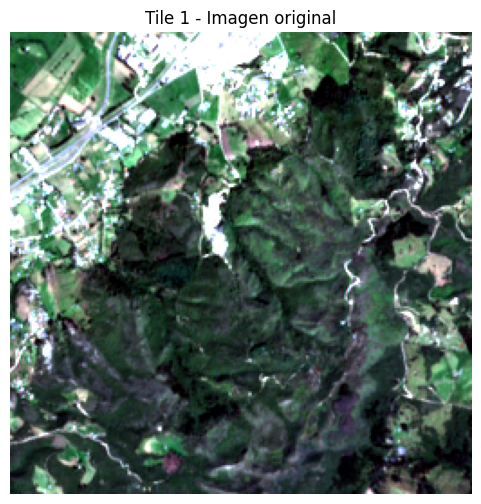

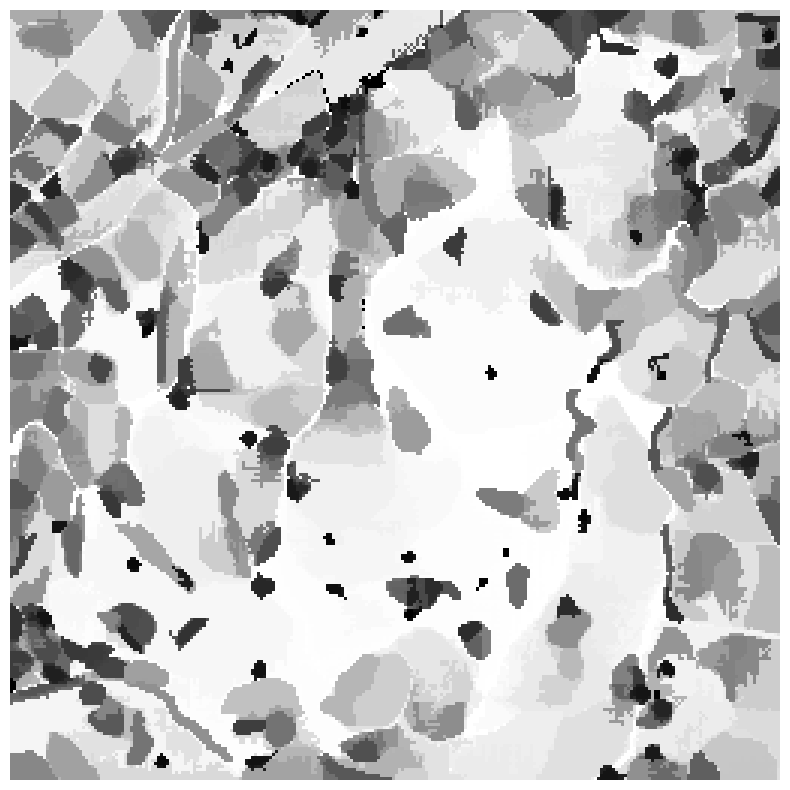

⚠️ Máscara 1 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 2 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 3 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 4 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 5 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 6 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 7 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 8 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 9 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 10 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 11 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 12 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 13 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 14 no tiene geometría v

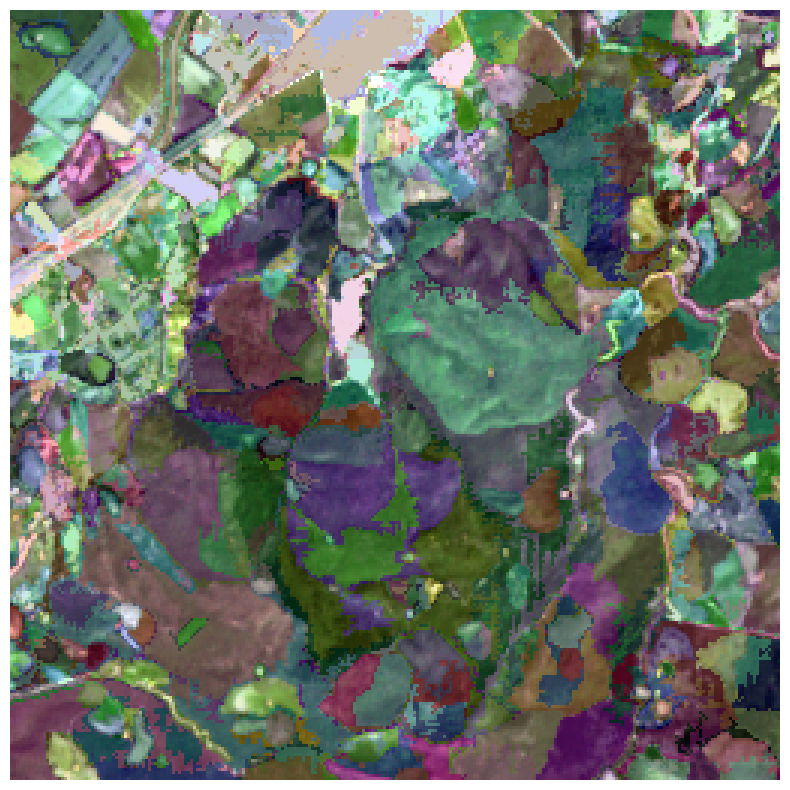

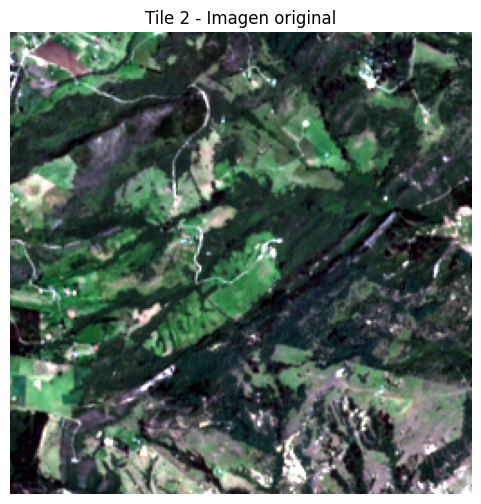

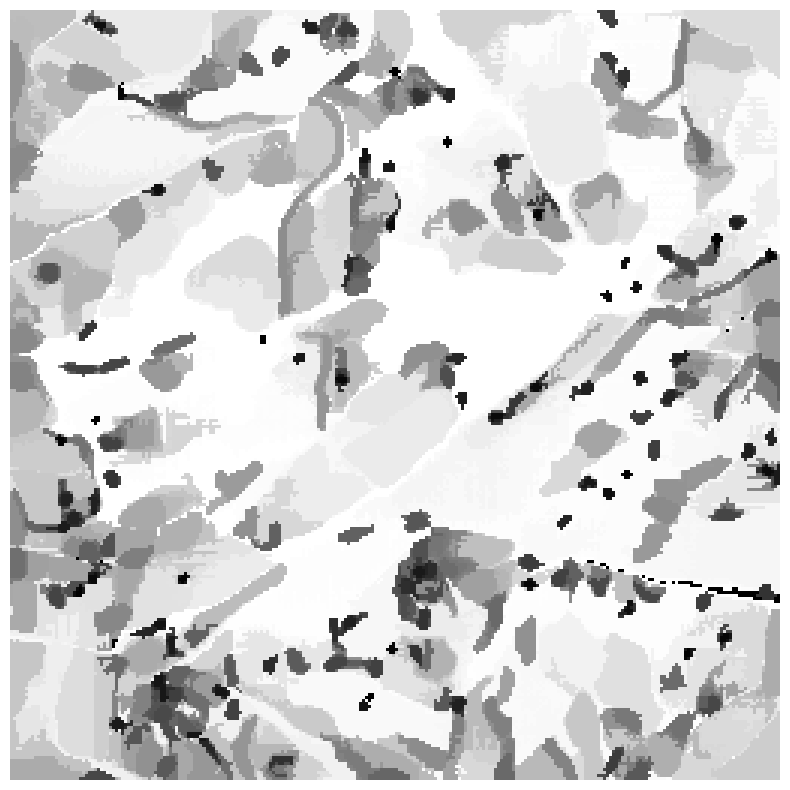

⚠️ Máscara 1 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 2 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 3 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 4 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 5 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 6 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 7 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 8 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 9 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 10 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 11 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 12 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 13 no tiene geometría válida (ni 'segmentation' ni 'geometry').
⚠️ Máscara 14 no tiene geometría v

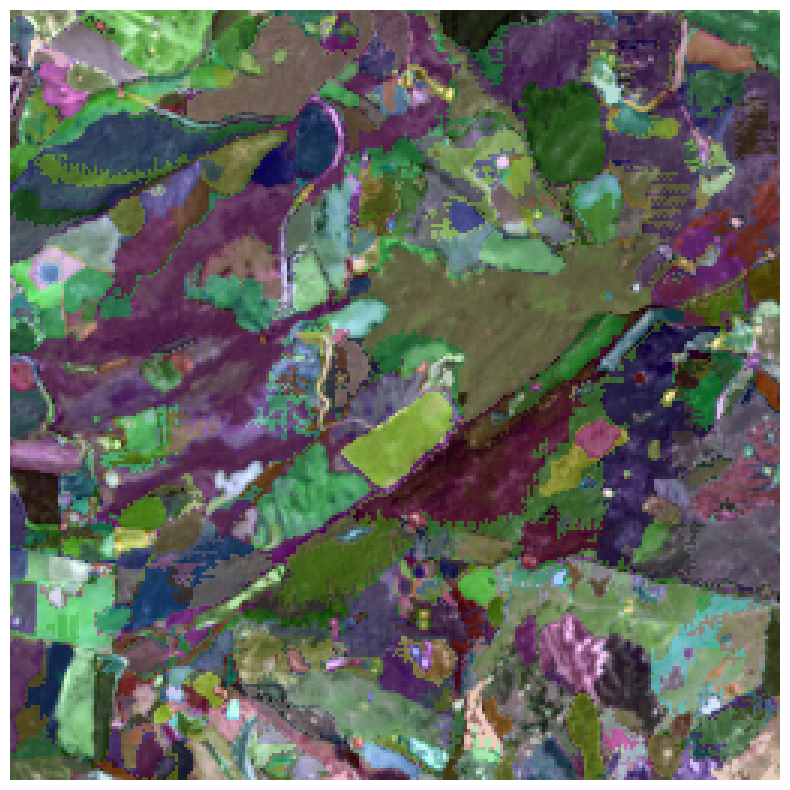

In [ ]:
# 📌 1. Librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import shape, LineString, MultiLineString
import geopandas as gpd
from samgeo import SamGeo
from datetime import datetime

# 📌 2. Parámetros de SAM
sam_kwargs = {
    "points_per_side": 324,
    "pred_iou_thresh": 0.5,
    "stability_score_thresh": 0.2,
    "crop_n_layers": 0,
    "crop_n_points_downscale_factor": 0,
    "min_mask_region_area": 100
}

sam = SamGeo(model_type="vit_h", automatic=True, erosion_kernel=(3, 3), sam_kwargs=sam_kwargs)

# 📌 3. Ruta de salida con timestamp y parámetros
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
param_summary = (
    f"pps{sam_kwargs['points_per_side']}_"
    f"iou{int(sam_kwargs['pred_iou_thresh'] * 100)}_"
    f"stab{int(sam_kwargs['stability_score_thresh'] * 100)}_"
    f"crop{sam_kwargs['crop_n_layers']}_"
    f"area{sam_kwargs['min_mask_region_area']}"
)

output_dir = "/content/drive/MyDrive/Sentinel_Export/Mascaras_GeoJSON"
os.makedirs(output_dir, exist_ok=True)

output_geojson = os.path.join(output_dir, f"masks_tile1y2_{param_summary}_{timestamp}.geojson")

# 📌 4. Procesar solo los dos primeros tiles
geoms_tiles = []

for i, tile in enumerate(valid_tiles_uint8[:2]):
    print(f"\n🧩 Tile {i+1}: tipo={tile.dtype}, rango=({tile.min():.2f}, {tile.max():.2f})")

    try:
        _ = sam.generate(source=tile)
        masks = sam.masks

        if not masks:
            print("⚠️ No se generaron máscaras.")
            continue

        # Visualización del tile original
        tile_rgb = np.stack([tile[:, :, 2], tile[:, :, 1], tile[:, :, 0]], axis=-1)
        plt.figure(figsize=(6, 6))
        plt.imshow(tile_rgb)
        plt.title(f"Tile {i+1} - Imagen original")
        plt.axis('off')
        plt.show()

        # Mostrar máscaras
        sam.show_masks()
        sam.show_anns()

        # Extraer líneas desde las máscaras
        for idx, m in enumerate(masks, start=1):
            # ✅ Corrección aquí: asegúrate de que sea una geometría válida (tipo dict)
            if isinstance(m.get("segmentation"), dict):
                geom_data = m["segmentation"]
            elif isinstance(m.get("geometry"), dict):
                geom_data = m["geometry"]
            else:
                print(f"⚠️ Máscara {idx} no tiene geometría válida (ni 'segmentation' ni 'geometry').")
                continue

            try:
                geom = shape(geom_data)
                if geom.is_empty or not geom.is_valid:
                    continue

                boundaries = geom.boundary
                if isinstance(boundaries, LineString):
                    geoms_tiles.append({
                        "geometry": boundaries,
                        "properties": {
                            "tile_id": i + 1,
                            "mask_id": idx,
                            "sam_params": param_summary
                        }
                    })
                elif isinstance(boundaries, MultiLineString):
                    for part in boundaries:
                        geoms_tiles.append({
                            "geometry": part,
                            "properties": {
                                "tile_id": i + 1,
                                "mask_id": idx,
                                "sam_params": param_summary
                            }
                        })
            except Exception as e:
                print(f"❌ Error en máscara {idx}: {e}")

        print(f"✅ Tile {i+1}: {len(masks)} máscaras convertidas a líneas.")

    except Exception as e:
        print(f"❌ Error procesando tile {i+1}: {e}")

# 📌 5. Crear GeoDataFrame si hay geometrías válidas
if geoms_tiles:
    gdf = gpd.GeoDataFrame.from_features(geoms_tiles)
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"\n✅ GeoJSON guardado: {output_geojson}")
    print(f"🔎 Total de líneas generadas: {len(gdf)}")

    # 📌 6. Visualización final
    gdf.plot(figsize=(10, 10), cmap="tab20", edgecolor="k")
    plt.title(f"🗺️ Máscaras SAM como líneas\n({param_summary}, {timestamp})")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ No se generó ninguna línea válida.")


In [ ]:
from shapely.geometry import box
import geopandas as gpd
from rasterio.transform import from_bounds

# Crear transform (solo si no lo tienes aún)
minx, miny, maxx, maxy = guativita_gdf.bounds.iloc[0]
transform = from_bounds(minx, miny, maxx, maxy, width=w, height=h)
xres = transform.a
yres = -transform.e  # Negativo porque las filas crecen hacia abajo en imagen

tile_geoms = []
tile_ids = []

# Solo tomamos los primeros 2 tiles
max_tiles = 2
count = 0

tile_size = tile_size_uint8 # Use the previously defined tile size for uint8

for row in range(0, h - tile_size + 1, tile_size):
    for col in range(0, w - tile_size + 1, tile_size):
        if count >= max_tiles:
            break

        # Tile numpy y verificación de contenido
        tile = rgb_norm[row:row + tile_size, col:col + tile_size, :]
        if not np.any(tile > 0):
            continue

        # Geometría correctamente posicionada
        x0 = minx + col * xres
        x1 = minx + (col + tile_size) * xres
        y1 = maxy - row * yres
        y0 = maxy - (row + tile_size) * yres

        geom = box(x0, y0, x1, y1)

        if guativita_geom.intersects(geom):
            tile_geoms.append(geom)
            tile_ids.append(f"tile_{count+1:02d}")
            count += 1

# Crear GeoDataFrame
tiles_gdf = gpd.GeoDataFrame({'tile_id': tile_ids, 'geometry': tile_geoms}, crs="EPSG:4326")

# Guardar GeoJSON
tiles_gdf.to_file("tiles_prueba.geojson", driver="GeoJSON")
print("✅ GeoJSON de prueba generado con 2 tiles corregidos.")

✅ GeoJSON de prueba generado con 2 tiles corregidos.
